Le but ici de cette première tache est de créer un "raster plot" qui montre la reproducibilité d'un train de spike avec des répétitions du même stimulus. En particulier, nous allons essayer de répliquer la figure 1 de [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf). 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width = 15
phi = (np.sqrt(5)+1)/2
phi = phi**2

# Mainen & Sejnowski, 1995

## contexte
Le but de cette première tache est de créer un "raster plot" qui montre la reproducibilité d'un train de spike avec des répétitions du même stimulus, comme dans ce travail dans la [rétine de rongeurs](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/3) ou dans le [cortex (V1) du chat](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/6).

Ici, nous allons essayer de répliquer la figure 1 de [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf):

![Mainen Sejnowski 1995](http://i.stack.imgur.com/ixnrz.png "figure 1")


TODO: écrire un résumé rapide du papier (max 5 lignes) et pourquoi ce résultat est *a priori* surprenant:

 Le but de l’étude était de déterminer directement la précision temporelle avec laquelle les neurones corticaux sont capables d'encoder un stimulus dans un train de pics. Lors d'un examen de la fiabilité de la génération de pics à l'aide d'enregistrements de neurones dans des tranches néocorticales de rats. 
 Les auteurs ont mis en évidence que les neurones corticaux peuvent répondre de manière fiable à des fluctuations d'entrée relativement faibles. Une irrégularité dans le timing des pics peut alors refléter la présence d'informations.


# représentation du temps

In [2]:
time = np.arange(0, 1000, .5)

Création d'une fonction temporelle (version séquentielle):

In [3]:
start = 150
end = 750
value = 200

def Inp(time=time, start=start, end=end):
    x=[]
    for t in range(len(time)):
        if start < time[t] < end :
            x.append(value)
        else:
            x.append(0)
    return x

I = Inp(time)


In [4]:
%%timeit
I = Inp(time)

The slowest run took 4.43 times longer than the fastest. This could mean that an intermediate result is being cached.
2.62 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


version vectorisée:

In [5]:
def Inp(time=time, start=start, end=end, value=value):
    I = np.zeros_like(time)
    I[time>start] = value
    I[time>end] = 0
    return I
  
I = Inp(time)

In [6]:
%%timeit
I = Inp(time)

24.7 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


TODO: essayer de décrire pourquoi le temps de calcul pour créer le vecteur est différent dans les deux versions:

Le temps de calcule pour créer un vecteur est différent, il est plus rapide, il vise à accélérer l'exécution des boucles de programmation. La vectorisation automatique du code, est une fonctionnalité du compilateur qui permet à certaines parties des programmes séquentiels d'être transformés en programme parallèles équivalents afin de produire du code qui sera bien utilisé par un processeur vectoriel.

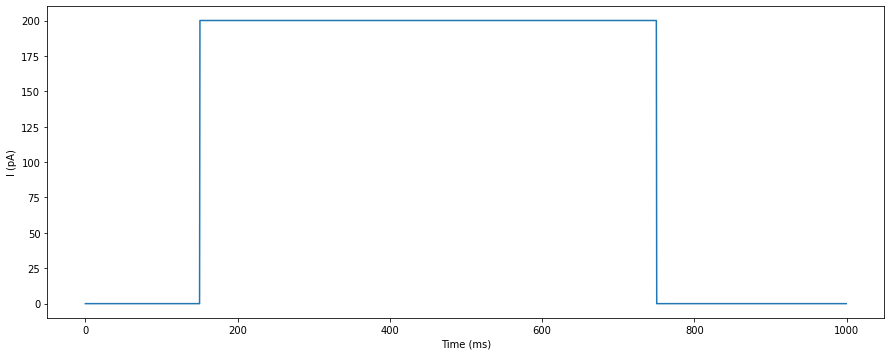

In [7]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width/phi))
ax.plot(time, I)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I (pA)');

TODO: relancer ce calcul en ajustant les paramètres pour correspondre à la figure 1

## un modèle simple de neurone intègre-et-tire `leaky_IF`

Commençons avec cet équation du potentiel membranaire:

$$
\tau \cdot \frac{dV}{dt} = -(V - V_{rest}) + R*I(t)
$$

avec émission d'un "spike" si $V > V_{rest}$, et alors $V= V_{rest}$ pour $3 ms$.


In [8]:
Vthreshold = -53
def leaky_IF(time=time, inp=I, tau=30, v0=-69, R=0.082, 
                Vthreshold=Vthreshold, Vreset=-80, Vspike=30, 
                VRest=-70):
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        n=np.random.randn()
        dV = dt * (-(V[t] - VRest) + R*inp[t])/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V

V = leaky_IF(time, I)


TODO: régler le paramètre $R$ pour obtenir une dizaine de potentiels d'action - quel est l'interprétation de ce paramètre et quelles est l'unité de mesure?

R définit la résistance de la membrane. Plus la résistance augmente, plus la variation de potentiel induite par un courant sera importante. Son unité de mesure: l'ohms/cm.

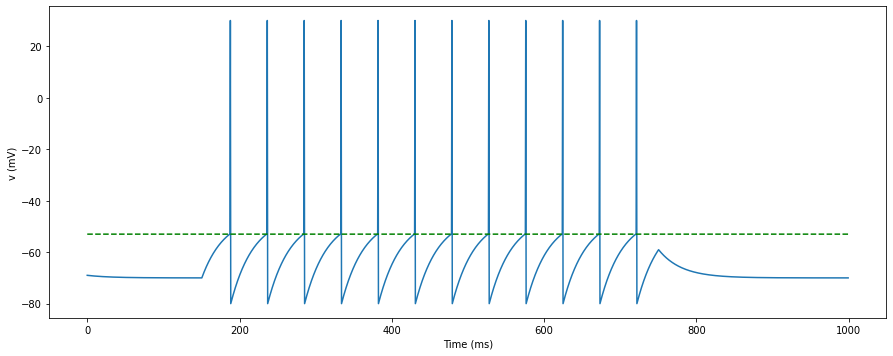

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

TODO: quel est l'effet de $I_0$ sur la fréquence de décharge?

L'effet de I0, (l'intensité du courant entrant injecté, correspond à l'injection d'un courant constant), plus la valeur est haute, plus la fréquence de décharge augmente.

I_0= 75.0


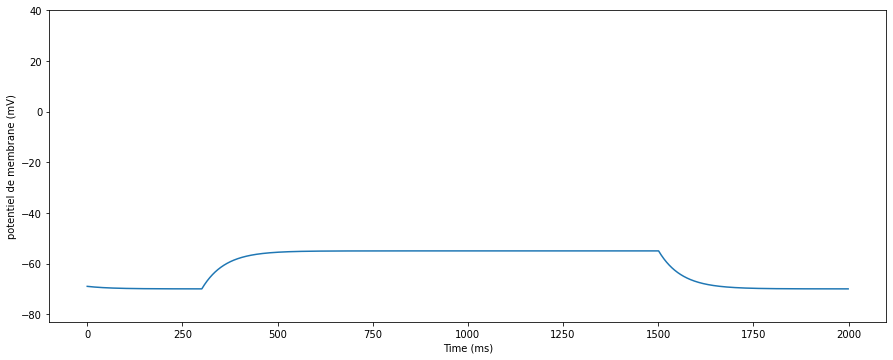

I_0= 101.25


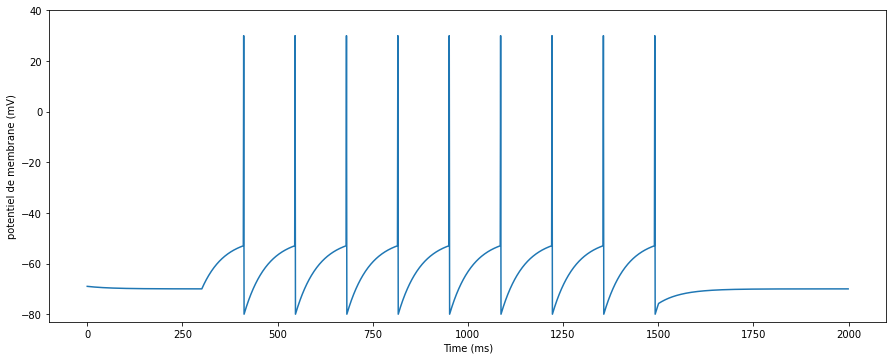

I_0= 127.5


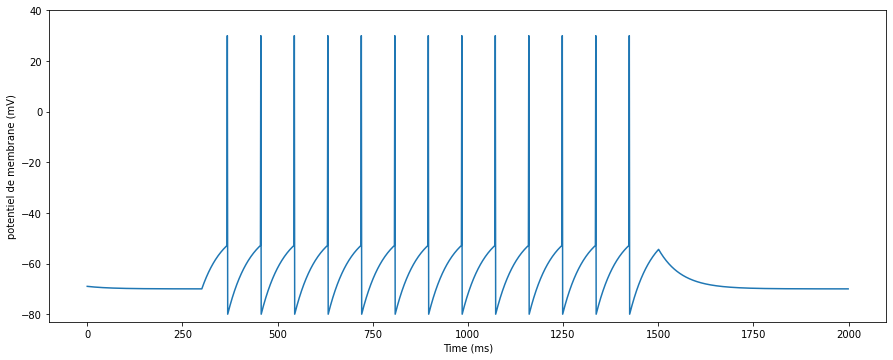

I_0= 153.75


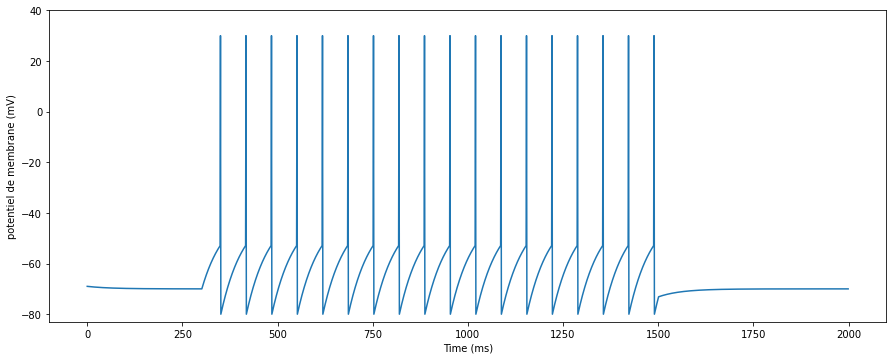

I_0= 180.0


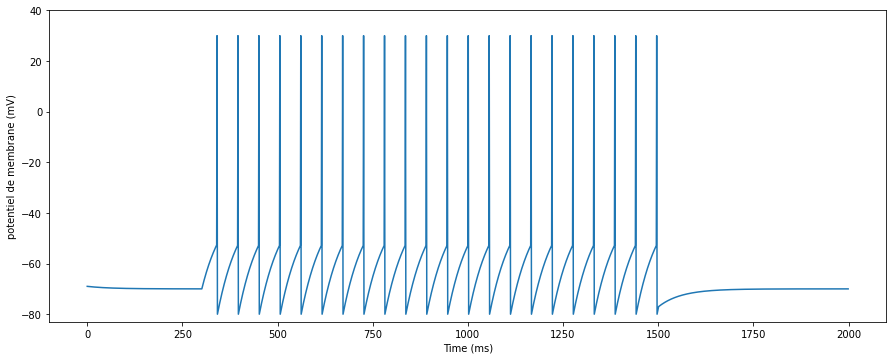

In [10]:
for rho in np.linspace(0.5, 1.2, 5):
    print('I_0=', rho*150)
    V= leaky_IF(time, Inp(value=rho*250))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

Plusieurs essais montrent que c'est parfaitement reproductible, contrairement à la figure:

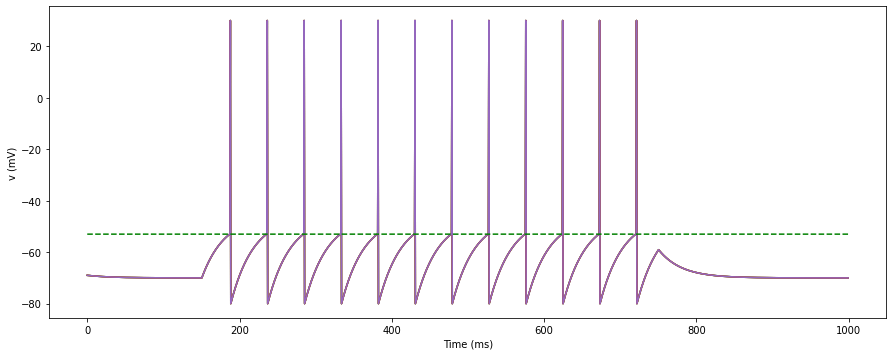

In [11]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF()

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

TODO: ce modèle semble ne pas reproduire les résultats, une explication?

Ce modèle ne semble pas reproduire les résultats, car l'intensité du courant est continue et non fluctuant.

## Création d'un input bruité

Un modèle linéaire de diffusion permet de créer simplement un bruit:

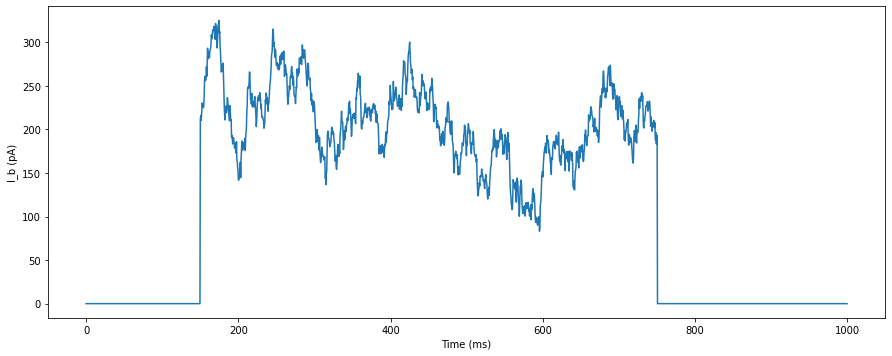

In [12]:
def Bruit(time=time, tau_n=30, I_n=100, I_0=150, start=start, end=end):
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1]=(1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0, 0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

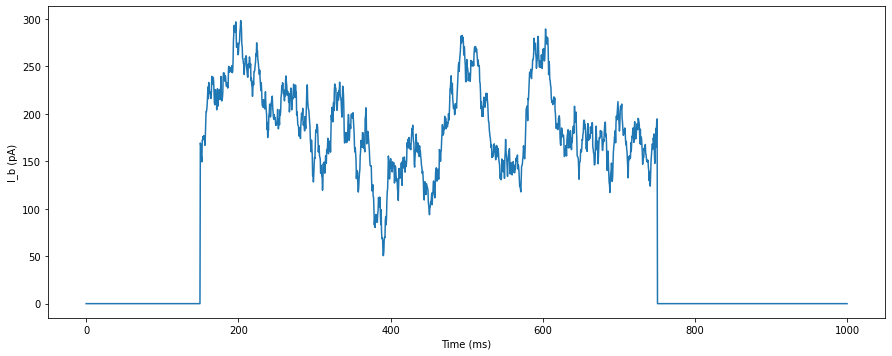

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

TODO: ce modèle représente-t-il bien celui dans le papier? régler $I_n$ et $I_0$ pour obtenir quelque chose qui corresponde mieux.
Ce modèle ne présente pas celui dans le papier, il faut adapter les paramètres:
In = 100pA et I0 = 150pA

## Neurone LIF avec Input bruité

Observons maintenant la réponse de notre neurone LIF à cette entrée:

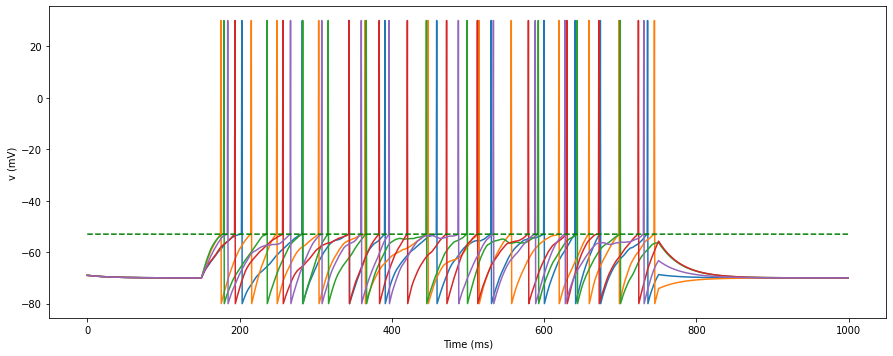

In [14]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit())

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

TODO: régler $I_n$ et $I_0$ pour obtenir quelque chose qui corresponde mieux:

I_0= 75.0


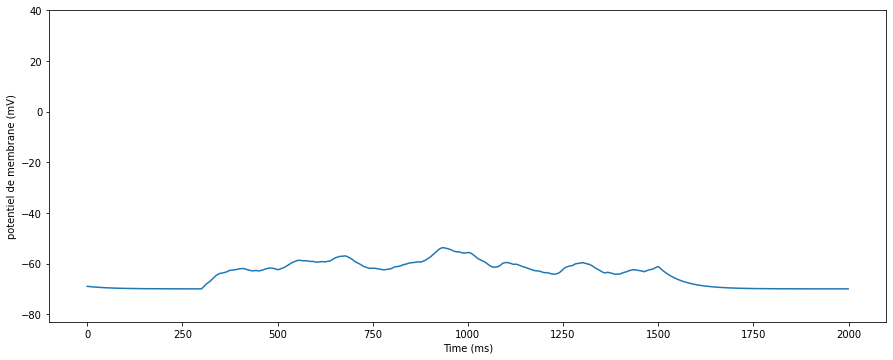

I_0= 101.25


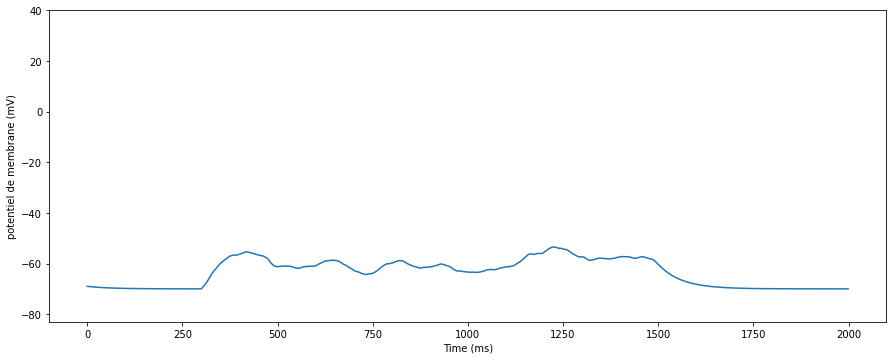

I_0= 127.5


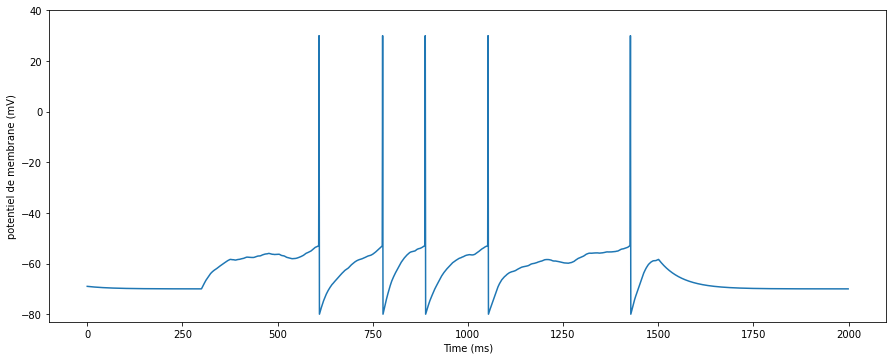

I_0= 153.75


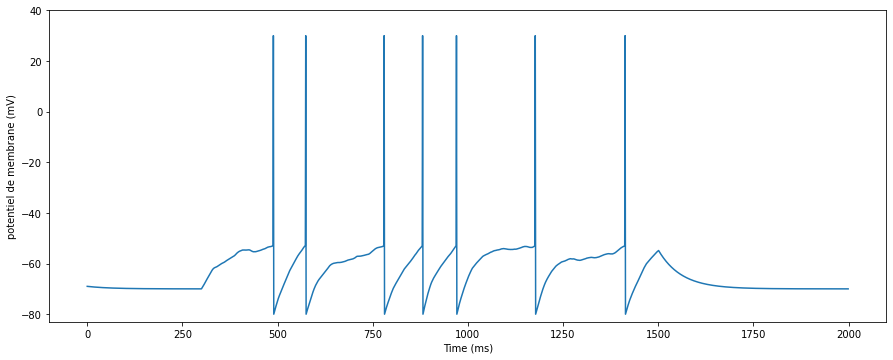

I_0= 180.0


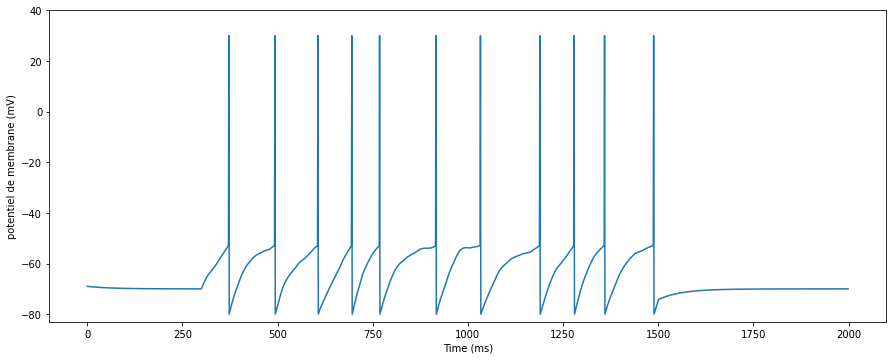

In [15]:
for rho in np.linspace(0.5, 1.2, 5):
    print('I_0=', rho*150)
    V= leaky_IF(time, Bruit(time, I_n=350, I_0=rho*150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

I_n= 300.0


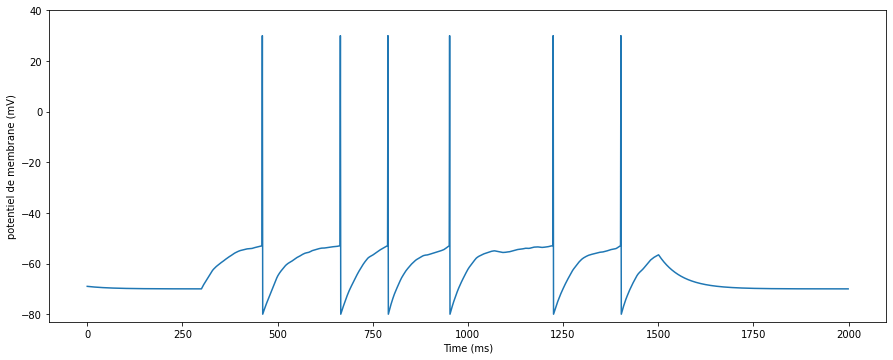

I_n= 399.99999999999994


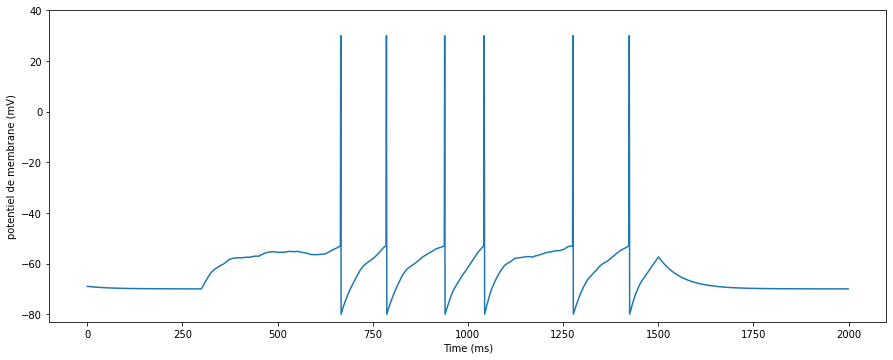

I_n= 500.0


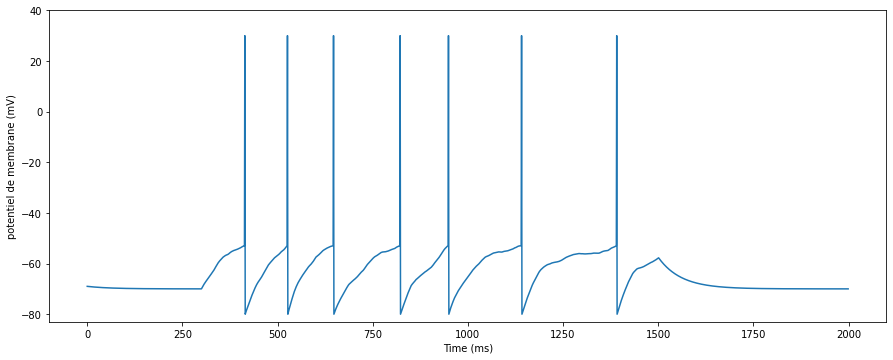

I_n= 600.0


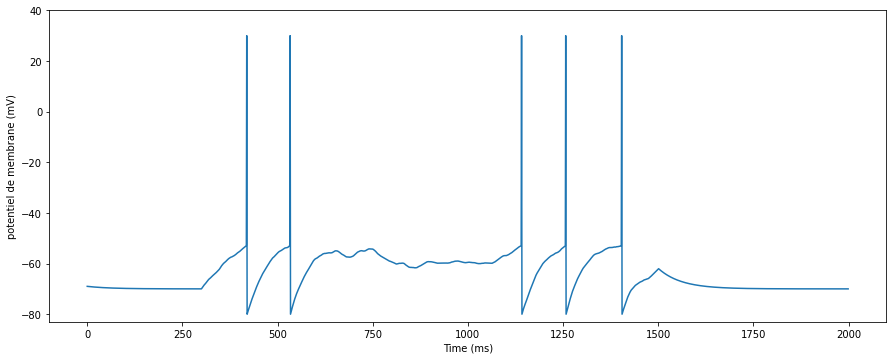

I_n= 700.0


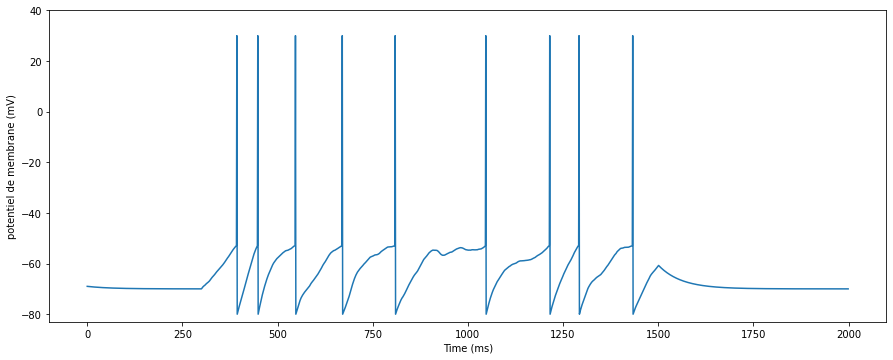

In [16]:
for rho in np.linspace(0.6, 1.4, 5):
    print('I_n=', rho*500)
    V= leaky_IF(time, Bruit(time, I_n=rho*500, I_0=250))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

TODO: obtient-on bien quelque chose de reproductible?

Non

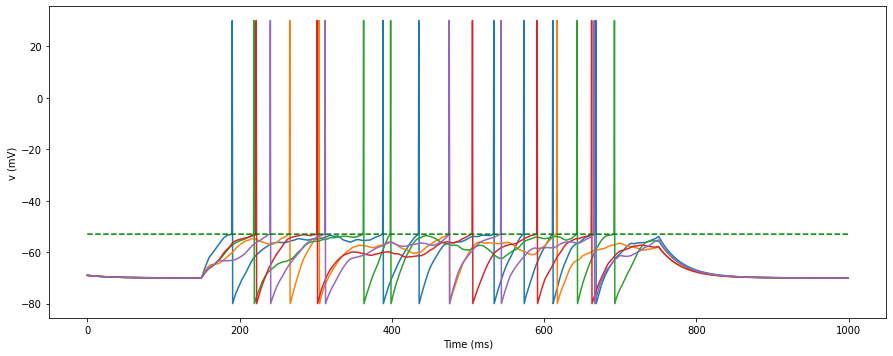

In [17]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit(time, I_n=325, I_0=250))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

## bruit gelé

#### TODO : quel est la nature du bruit utilisé dans l'article? pourquoi peut-on le décrire comme un [bruit gelé](https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095836900) ?

La nature du bruit utilisé dans l'article est un bruit blanc Gaussien filtré généré par ordinateur.
(Le bruit blanc gaussien est un bruit blanc qui suit une loi normale de moyenne et variance données. Des générateurs de signaux aléatoires (signal de bruit) sont utilisés pour des essais de dispositifs de transmission et, à faible niveau, pour l'amélioration des systèmes numérique.)

On peut le décrire comme un "bruit gelé", c'est un bruit blanc fixe et Gaussien qui se répète.

TODO : comment implanter un tel bruit? que savez-vous des générateurs de bruit utilisés dans un ordinateur?

On peut implanter ce bruit par informatique en "gelant" les inputs.
Les générateurs de bruit utilisés dans un ordinateur, servent à générer un signal de bruit précis tout en maintenant une haute précision du ratio entre le bruit fourni par l'utilisateur et le bruit interne, au dessus de la gamme étendue du niveau de puissance et de fréquence du signal.


In [18]:
help(np.random.seed)

Help on built-in function seed:

seed(...) method of numpy.random.mtrand.RandomState instance
    seed(self, seed=None)
    
    Reseed a legacy MT19937 BitGenerator
    
    Notes
    -----
    This is a convenience, legacy function.
    
    The best practice is to **not** reseed a BitGenerator, rather to
    recreate a new one. This method is here for legacy reasons.
    This example demonstrates best practice.
    
    >>> from numpy.random import MT19937
    >>> from numpy.random import RandomState, SeedSequence
    >>> rs = RandomState(MT19937(SeedSequence(123456789)))
    # Later, you want to restart the stream
    >>> rs = RandomState(MT19937(SeedSequence(987654321)))



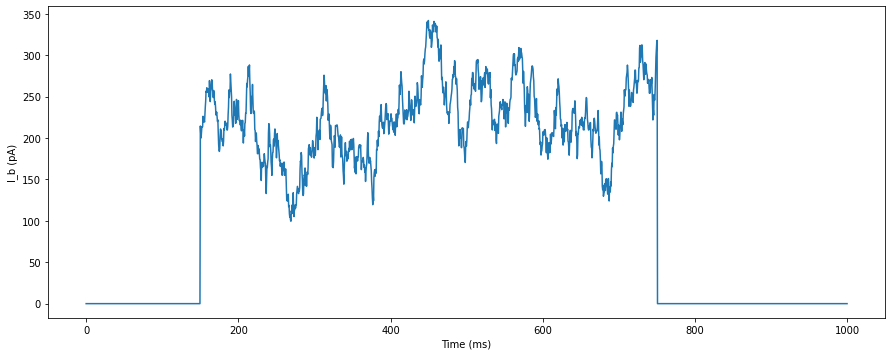

In [19]:
def Bruit(time=time, tau_n=20, I_n=400, I_0=200, seed=42, start=start, end=end):
    np.random.seed(seed)
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1] = (1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0,0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

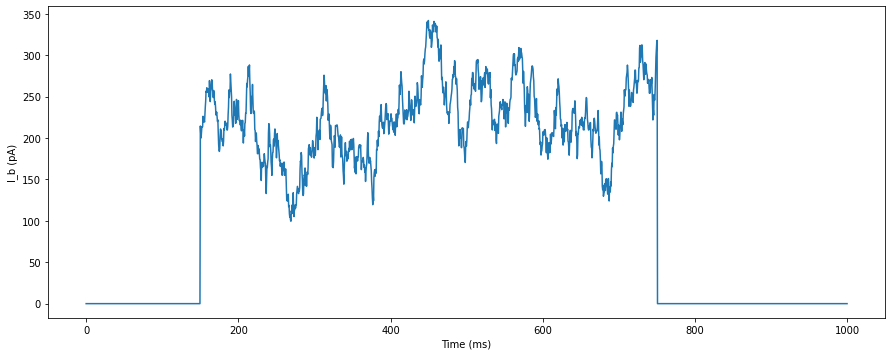

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

## Plusieurs trials
Ici on montre le maintien du temps des spikes en utilisant un input bruité (bruit gelé)

TODO: régler le paramètre $I_0$ et $I_n$ pour obtenir une dizaine de potentiels d'action:

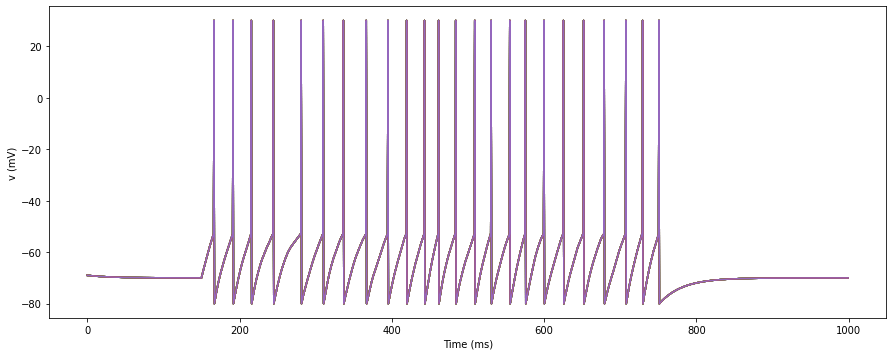

In [21]:
n_trials = 25
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit(I_n=815, I_0=250))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');


On reproduit le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles.

Celà prouve aussi que l'on a "oublié" d'inclure un bruit intrinsèque à la dynamique du neurone:

In [22]:
def leaky_IF(time=time, inp=I, tau=30, v0=-65, R=0.12, 
                Vthreshold =-53, Vreset = -80, Vspike=30, 
                VRest=-70, b=100, seed=None):
    np.random.seed(seed)
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        n=np.random.randn()
        dV = dt * (-(V[t] - VRest) + R*(inp[t]+b*n))/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V


Plusieurs essais montrent qu'avec un créneau les temps des spikes perdent leur reproducibilité, comme sur la figure:

TODO : régler $I_0$ et $I_n$ pour obtenir un nombre qualitativement similaire de spikes en sortie du neurone. Pour celà, essayer de controler le nombre de spikes :

rho= 0.7
number of spikes per trial : [12 12 12 12 12 12 11 12 12 12 12 12 12 11 12 11 12 12 11 12 12 12 11 12
 12]


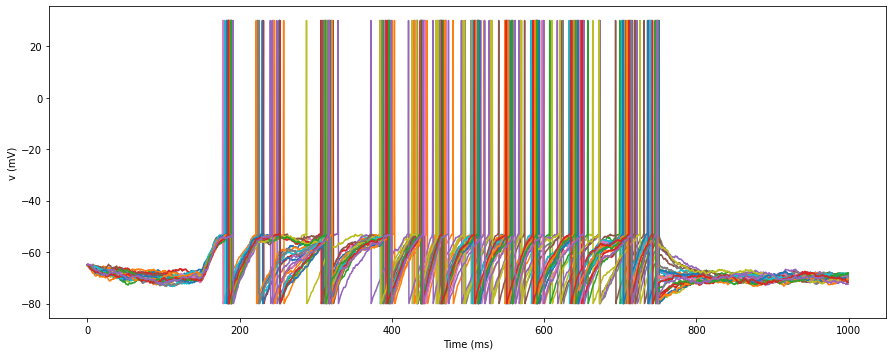

rho= 0.85
number of spikes per trial : [12 13 12 13 13 13 12 12 12 12 12 13 12 12 12 13 12 13 13 13 12 13 12 12
 11]


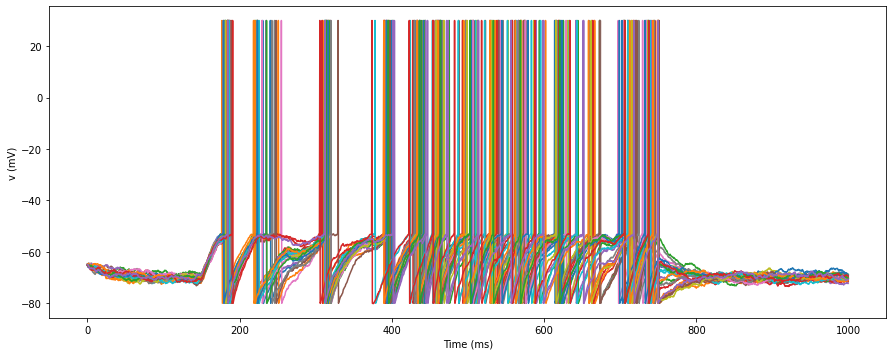

rho= 1.0
number of spikes per trial : [13 13 13 13 12 13 13 13 13 13 13 13 13 13 13 13 13 13 12 13 13 13 12 12
 13]


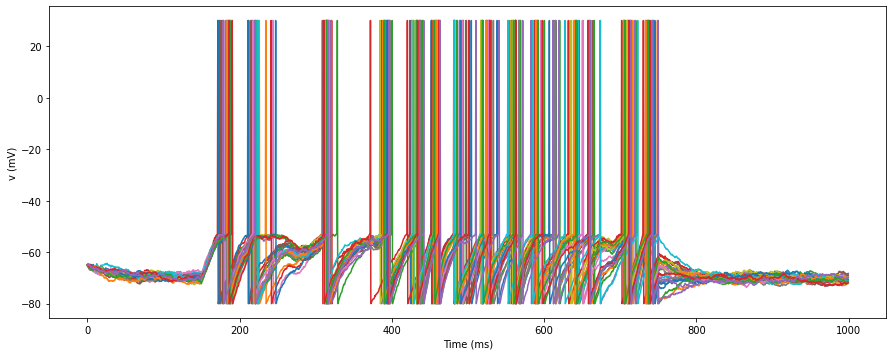

rho= 1.15
number of spikes per trial : [13 14 14 13 14 14 13 13 14 13 13 13 13 13 13 13 13 13 13 13 12 12 13 14
 13]


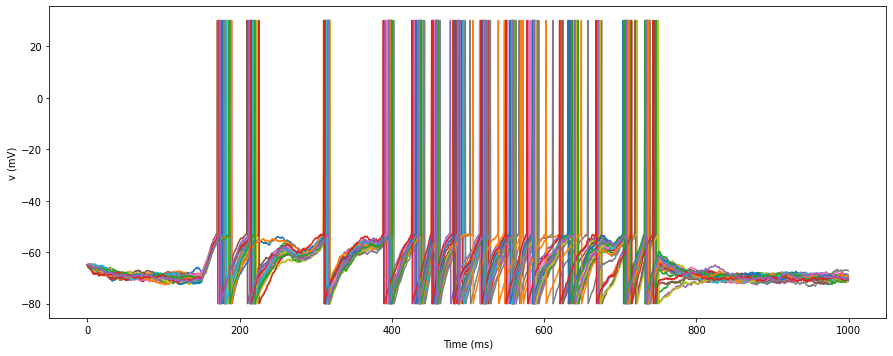

rho= 1.3
number of spikes per trial : [14 14 14 14 14 14 14 14 14 14 14 13 14 14 13 14 14 13 14 14 14 14 14 14
 14]


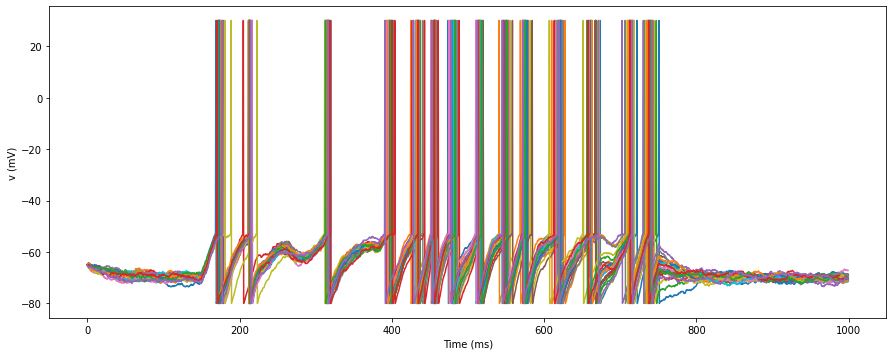

In [31]:
for rho in np.linspace(0.7, 1.3, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=rho*200, I_0=144))

    print('number of spikes per trial :', (VA>0).sum(axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

TODO : voir l'influence de $I_0$ sur le comportement


rho= 0.7


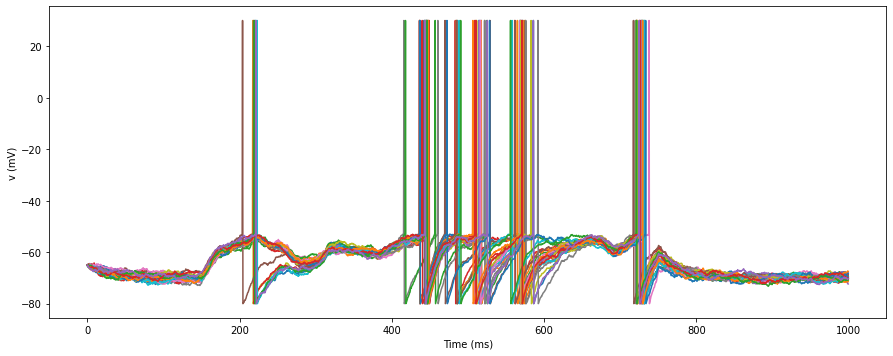

rho= 0.85


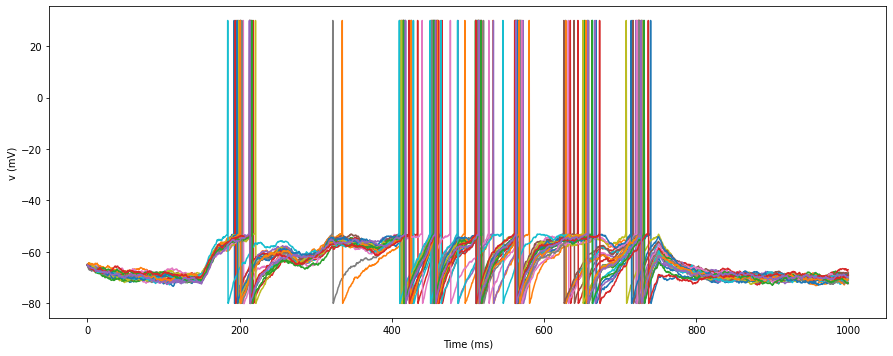

rho= 1.0


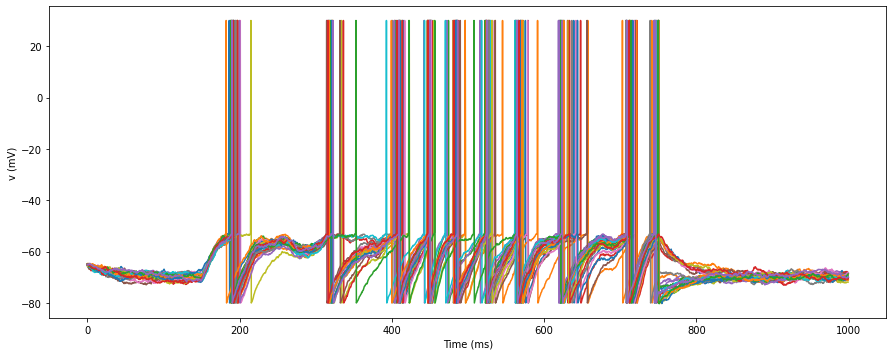

rho= 1.15


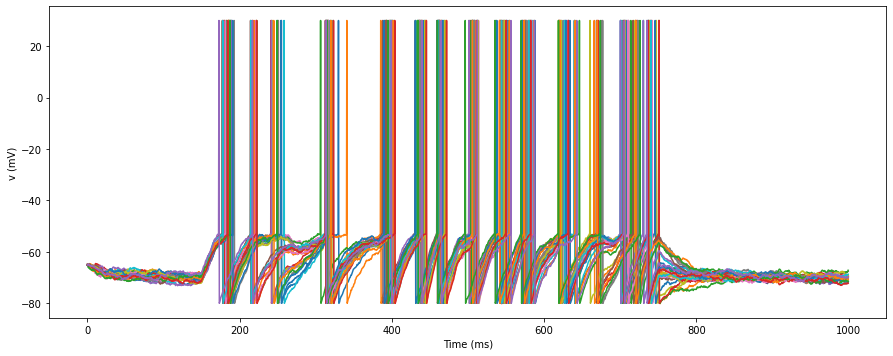

rho= 1.3


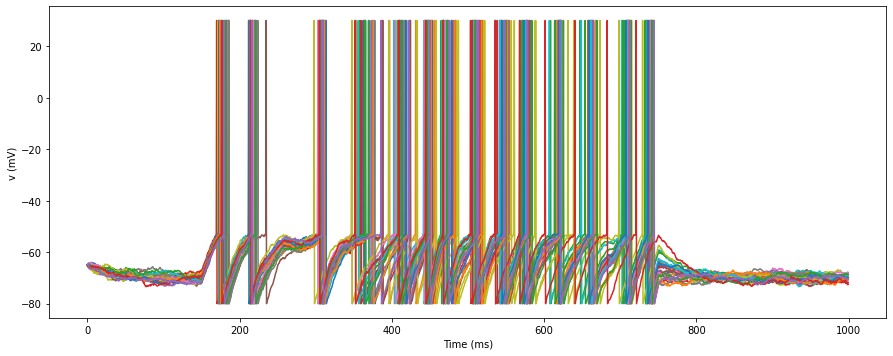

In [24]:
for rho in np.linspace(0.7, 1.3, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=500, I_0=rho*150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

TODO : voir l'influence de $I_0$ sur le comportement, *quand le bruit est nul* :

rho= 0.9


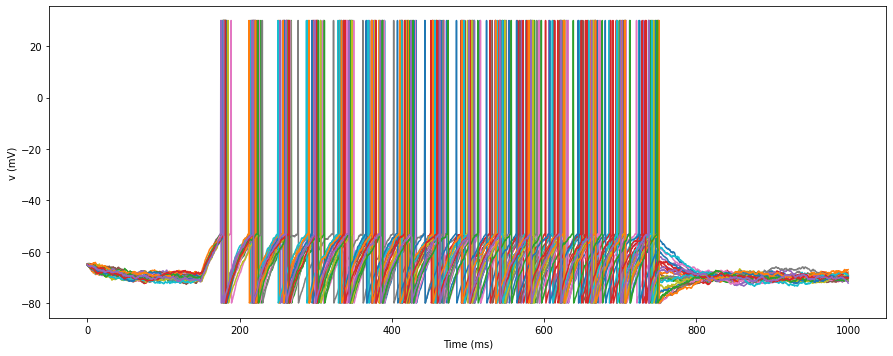

rho= 0.9500000000000001


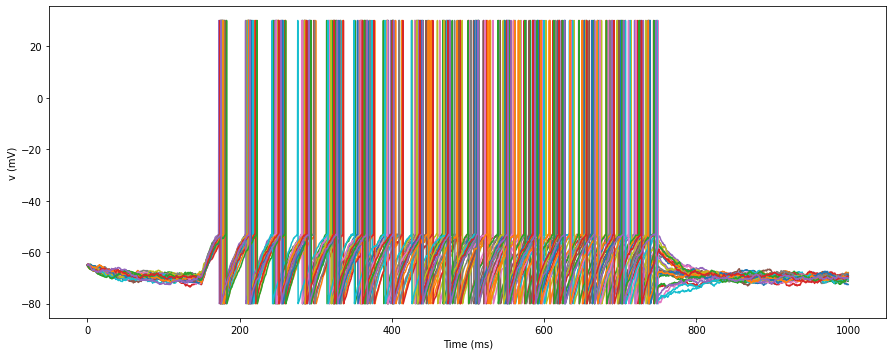

rho= 1.0


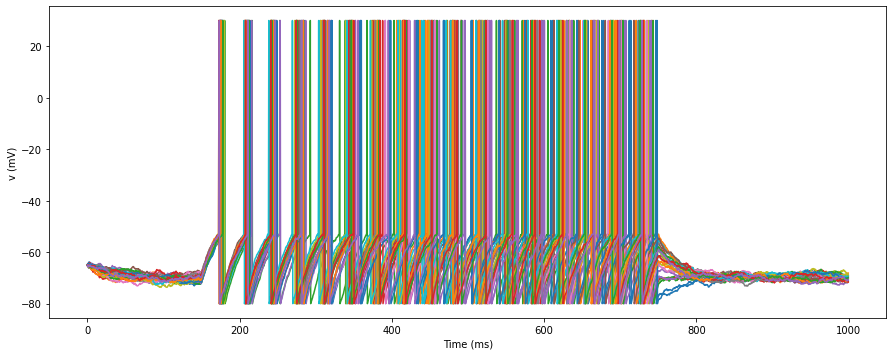

rho= 1.05


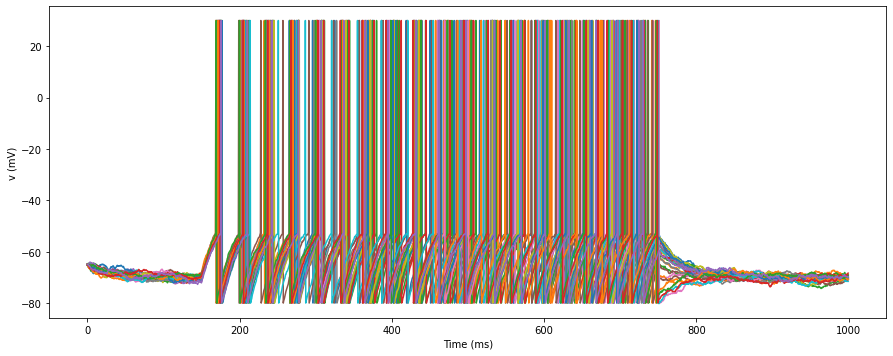

rho= 1.1


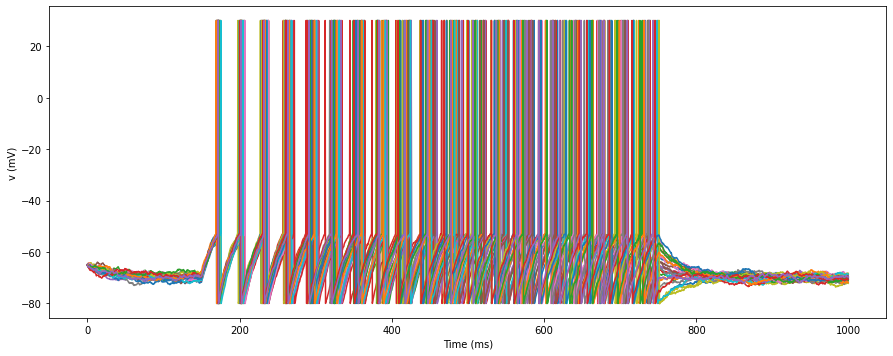

In [25]:
for rho in np.linspace(0.9, 1.1, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=0, I_0=rho*250))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

TODO: reproduire le paneau A: quand le bruit est nul, les traces des neurones ne sont pas reproductibles:

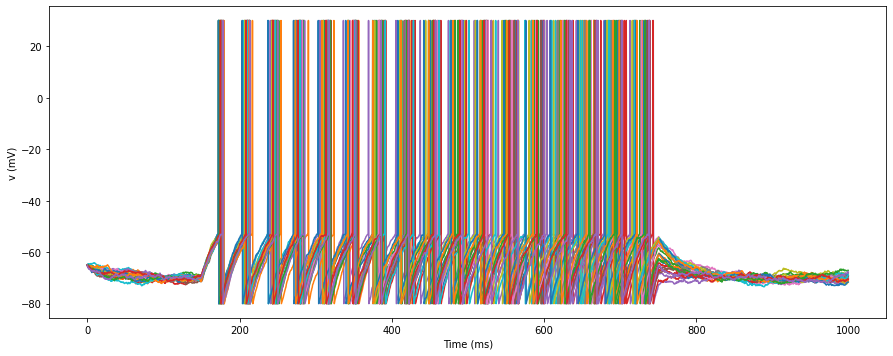

In [26]:
seed = 2020
VA = np.zeros((n_trials,len(time)))
b_A = Bruit(I_n=0, I_0=250, seed=seed)

for i in range(n_trials):
    VA[i, :] = leaky_IF(time, b_A)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VA.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');


On reproduit le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles, même quand le neurone possède un bruit intrinsèque:


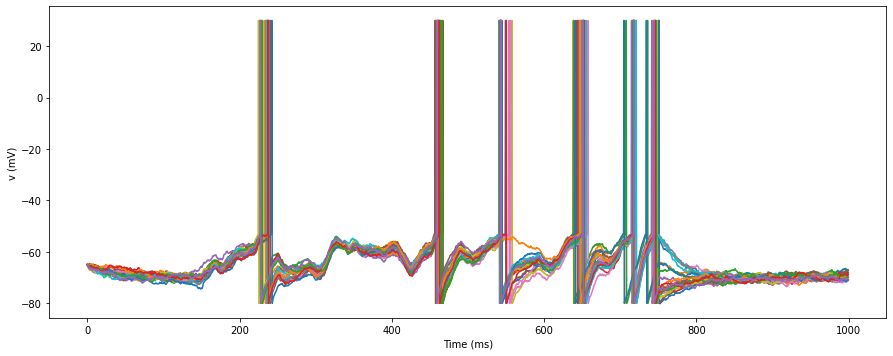

In [27]:
VB = np.zeros((n_trials, len(time)))
b_B = Bruit(I_n=1000, I_0=125, seed=seed)
for i in range(n_trials):
    VB[i, :] = leaky_IF(time, b_B)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VB.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

Pour résumer:

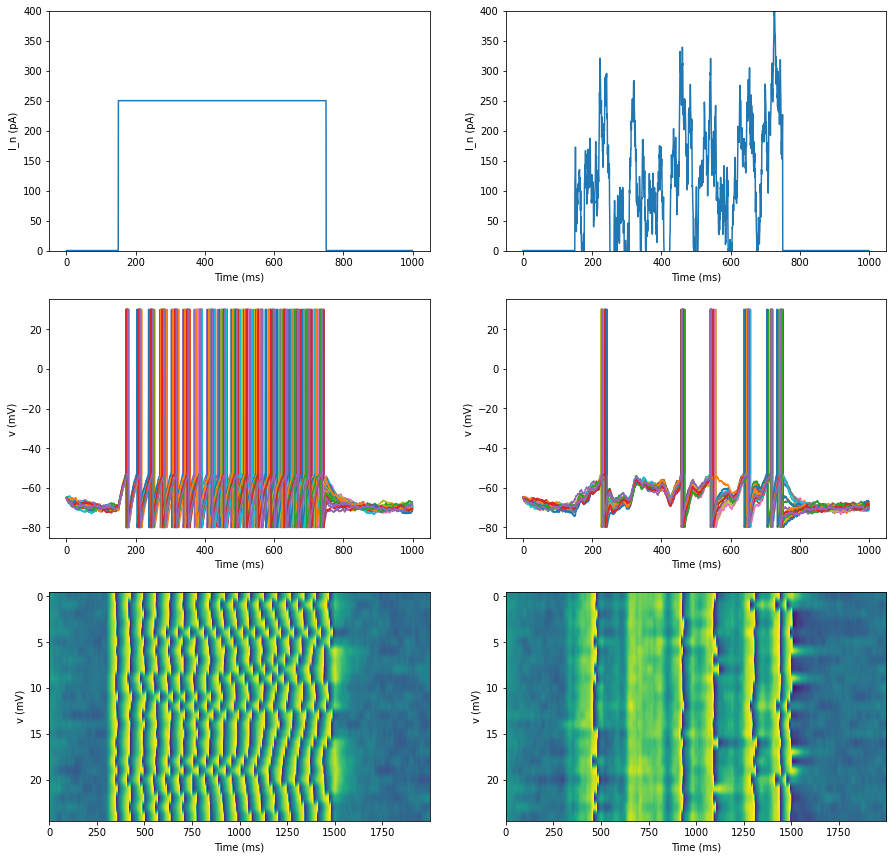

In [28]:
fig, axs = plt.subplots(3, 2, figsize=(fig_width, fig_width))

axs[0][0].plot(time, b_A)
axs[0][1].plot(time, b_B)
axs[1][0].plot(time, VA.T)
axs[1][1].plot(time, VB.T)
axs[2][0].imshow(VA, aspect=len(time)/n_trials/1.66, vmax=Vthreshold)
axs[2][1].imshow(VB, aspect=len(time)/n_trials/1.66, vmax=Vthreshold)
for ax in axs.ravel(): 
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
for i in range(2):
    axs[0][i].set_ylabel('I_n (pA)')
    axs[0][i].set_ylim(0, 400);

TODO: conclure rapidement: à quel point a-t-on expliqué le phénomène? quelle est la conclusion sur la préférence des neurones à des signaux dynamiques?

On a expliqué ce phénomène en faisant varier la fluctuation du courant, notamment en adaptant la fréquence de décharge des spikes.
Les modèles de décharge sont reproductibles et sont un phénomène robuste en présence de fluctuations de stimulus.
Quand le bruit est nul les traces des neurones ne sont pas reproductibles, parcontre elles le sont avec "un bruit gelé" (même avec un bruit intrinsèque).
Les neurones montre une préférence pour les signaux bruités, dynamiques, qui permet donc le reflet d'une transmisson d'information fiable et précise.